# Supplementary Materials for "Classifying Classifying Evolutionary Forces in Language Change Using Neural Networks"

**_Folgert Karsdorp, Enrique Manjavacas, Lauren Fonteyn, and Mike Kestemont_**

## A Machine Learning Approach to Time Series Classification

In the paper, we conceptualize the task of detecting evolutionary forces in language and cultural change as a binary time series classification (TSC) task. To this end, we resort to a sequence classifier, which will map an input in the form of a time series vector to one of two category labels (i.e. `0` for the absence and `1` for the presence of selection pressure in a time series). Formally, given a data set $D$ consisting of $N$ pairs of time series $X_i$ and corresponding labels $Y_i \in {0, 1}$, i.e., $D = {(X_1, Y_1), (X_2, Y_2), \ldots, (X_N,
  Y_N)}$, the task of TSC is to learn a mapping function $f(X_i)$ for the input series to the output labels. $Y_i = 1$ when $X_i$ was produced under selection forces, and $Y_i = 0$ otherwise.

## Residual Networks

![Restnet](resnet.png)

As described in the paper, we employ Residual Networks as out classification system, which have been shown to act as a strong baseline, achieving high quality and efficiency on a rich variety of time series classification tasks. A Residual Neural Network is characterized by the addition of so-called 'skip-connections' that link the output of a layer with the output of another layer more than one level ahead. The network architecture underlying the present study consists of three residual blocks. Instead of plain linear transformations followed by a non-linear function, each residual block is composed of weights that are 'convolved' with the input vector. Each of these convolutional weights (typically known as a convolutional filters or kernels) is slided over the input values, generating a windowed feature vector for consecutive segments of the timeseries.

For the present study, each residual block consists of three convolutional blocks that have 64 filters of size 8, 128 of size 5 and 128 of size 3. The outputs of all convolutional filters are passed through the non-linear Rectified Linear Unit (ReLU) activation function and concatenated into an output matrix of dimensionality proportional to the input size and the number of filters. The output matrix of the last residual block is transformed into a single vector by averaging over the time dimension. Finally, this vector is passed into the last layer which outputs a scalar that is transformed into a probability with the logistic function.

\begin{align}
  y = \mathbf{W} \otimes \mathbf{x} + \mathbf{b} \\
  s = \textrm{BatchNorm}(y) \nonumber \\ 
  h = \textrm{ReLU}(s)      \nonumber
\end{align}

The ResNet is implemented in Python using the Pytorch library, and can be found in the file `src/nets.py` under the class `ResNet`:

In [37]:
%run ../src/nets.py

To initialize a Residual Network for our time series classification task, we set the number of input channels to 1, the number of filters of the first convolutional block to 64 (the remaining two are automatically set by multiplying the first by 2), and the number of output classes to 1, since we are dealing with a binary classification task:

In [38]:
model = ResNet(in_channels=1, mid_channels=64, num_pred_classes=1)

## Generation of Training Data

### Generating Time Series with the Wright-Fisher model

To effectively train the ResNet model, labeled training examples are required in order to optimize its weights (which are initialized randomly). To obtain this training material, we simulate artificial data using the Wright-Fisher model. In this section we describe and show how the training data has been generated. Using the Wright-Fisher model as described in Section 2.2.3 of the paper, we simulate time series representing frequency changes over time. The model assumes a population of constant size $N$ and discrete, non-overlapping generations. Let $z(t_i)$ be the number of times some cultural variant $A$ occurs in generation $t_i$, and let $f(t_i)$ be the relative frequency of that variant. Equation (4) in the paper, then, provides the linear evolutionary pressure function used to generate the time series, which is repeated here for convenience:

\begin{equation}
  g(f(t_i)) = \frac{(1 + \beta) f(t_i)}{(1 + \beta) f(t_i) + (1 - f(t_i))}
\end{equation}

Here, $\beta$ represents the bias towards selection of one of two variants of a cultural trait. The Wright-Fisher model is implemented in the Python function `wright_fisher`, which can be found in the file `src/simulation.py`. It can be used to generate time series with a variable number of generations (parameter `T`), different population sizes (parameter `N`), and varying selection coefficients (parameter `selection_strength`).

In [4]:
%run ../src/simulation.py

For example, to generate a time series based on a population size of $N=1000$ for $T=200$ timesteps without any selection pressure (i.e. $\beta = 0$), we can use the following lines of code:

In [56]:
neutral_series = wright_fisher(N=1000, T=200, start=0.5, selection_strength=0)

Similarly, to generate a time series with a positive selection pressure, we can write the following:

In [57]:
biased_series = wright_fisher(N=1000, T=200, start=0.5, selection_strength=0.02)

Using Python's plotting library Matplotlib, these series can be visualized as follows:

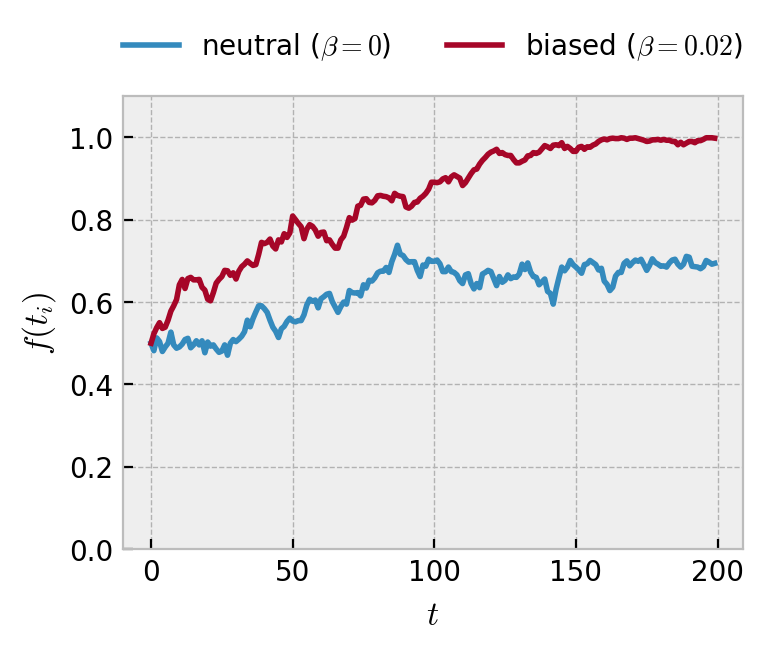

In [60]:
import matplotlib.pyplot as plt
plt.style.use("bmh")

fig, ax = plt.subplots(dpi=200, figsize=(4, 3))

# normalize the series before plotting
ax.plot(neutral_series / 1000, label="neutral ($\\beta=0$)")  
ax.plot(biased_series / 1000, label="biased ($\\beta=0.02$)")  

ax.set(xlabel="$t$", ylabel="$f(t_i)$", ylim=(0, 1.1))
plt.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.2), frameon=False);

Note that the `wright_fisher` function employs a random number generator, resulting in different time series each time the cells above are executed. To illustrate this, consider the following two graphs in which we simulate 100 time series with $\beta=0$ and 100 with $\beta=0.02$:

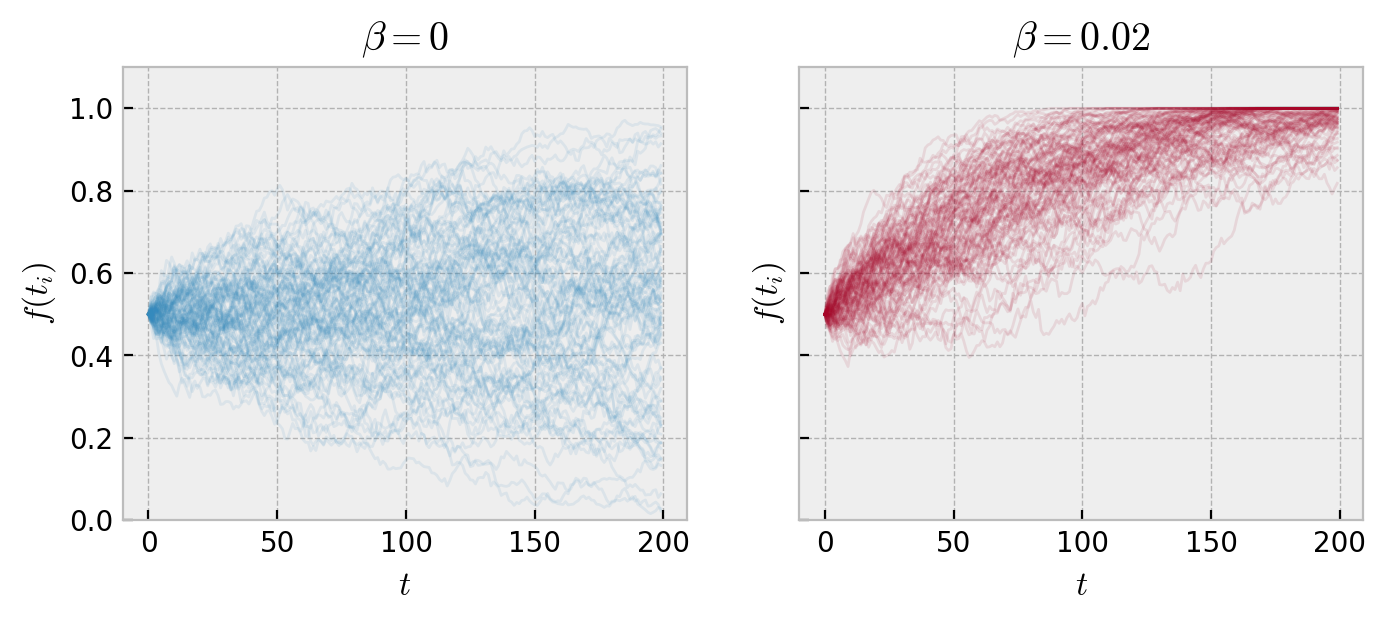

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=200, figsize=(8, 3), sharey=True)

for i in range(100):
    neutral_series = wright_fisher(N=1000, T=200, selection_strength=0) / 1000
    ax1.plot(neutral_series, alpha=0.1, color="C0", lw=1)
    
    biased_series = wright_fisher(N=1000, T=200, selection_strength=0.02) / 1000
    ax2.plot(biased_series, alpha=0.1, color="C1", lw=1)
    

ax1.set(xlabel="$t$", ylabel="$f(t_i)$", ylim=(0, 1.1), title="$\\beta=0$")
ax2.set(xlabel="$t$", ylabel="$f(t_i)$", ylim=(0, 1.1), title="$\\beta=0.02$");

One final detail of the `wright_fisher` function remains, which concerns the specification of a starting frequency. By default, this starting frequency is set to 0.5 (i.e. `start=0.5`). As explained in more detail below, for each training time series we sample a starting frequency at $t_i = 0$ from a uniform distribution $f(t_i) \sim \mathcal{U}(0.001, 0.999)$

### Data Distortion

In Section 2.2.4, the paper describes two data distortion strategies aimed at generating more realistic training samples and approximate real-world data abberations. The first strategy is to distort the generated frequencies by augmenting them with an error term $\delta$. For each time step $i = 1, 2, \ldots, T$, we sample $\delta$ from a normal distribution with zero mean and variance $\sigma=0.2$:

\begin{align}
  f(t_i) = f(t_i) + \delta_i \\
  \delta_i \sim \textrm{Normal}(0, \sigma) \nonumber
\end{align}
   
The augmented frequencies are subsequently truncated to the interval $[0, 1]$. To illustrate this strategy, consider the code block below in which we use the `Distorter` class (located in the file `src/utils.py` to alter the time series generated by the wright fisher model:

In [63]:
%run ../src/utils.py

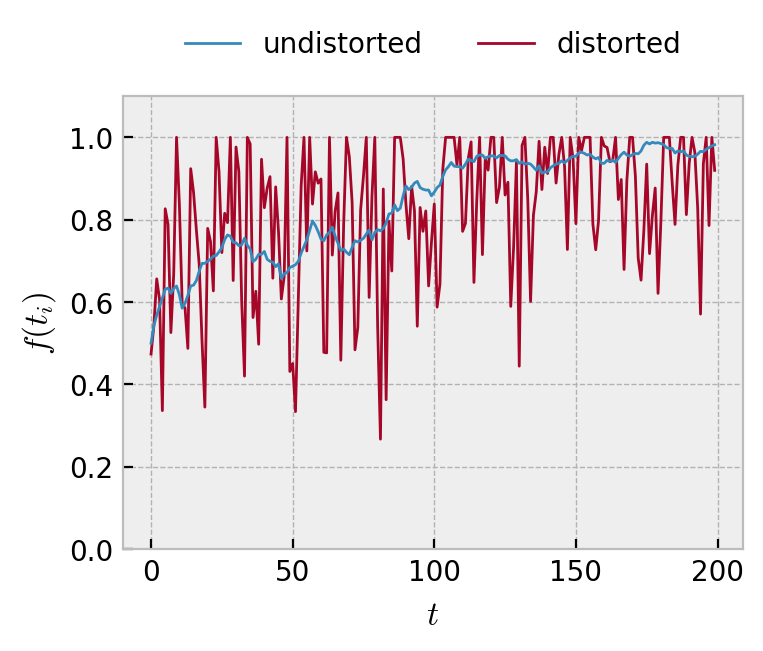

In [73]:
disorter = Distorter(loc=0, sd=0.2)
series = wright_fisher(N=1000, T=200, selection_strength=0.02) / 1000
distorted_series = disorter.distort(series)

fig, ax = plt.subplots(dpi=200, figsize=(4, 3))

# normalize the series before plotting
ax.plot(series, label="undistorted", lw=1, zorder=4)  
ax.plot(distorted_series, label="distorted", lw=1)  

ax.set(xlabel="$t$", ylabel="$f(t_i)$", ylim=(0, 1.1))
plt.legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.2), frameon=False);

The second strategy aims to mimic real-world time series distortions by grouping the time series into varying numbers of temporal segments ("bins"). Using this strategy, the generated counts are grouped into a number of bins (in the range $[4, T]$), and subsequently transformed into relative frequencies. A demo is given below:

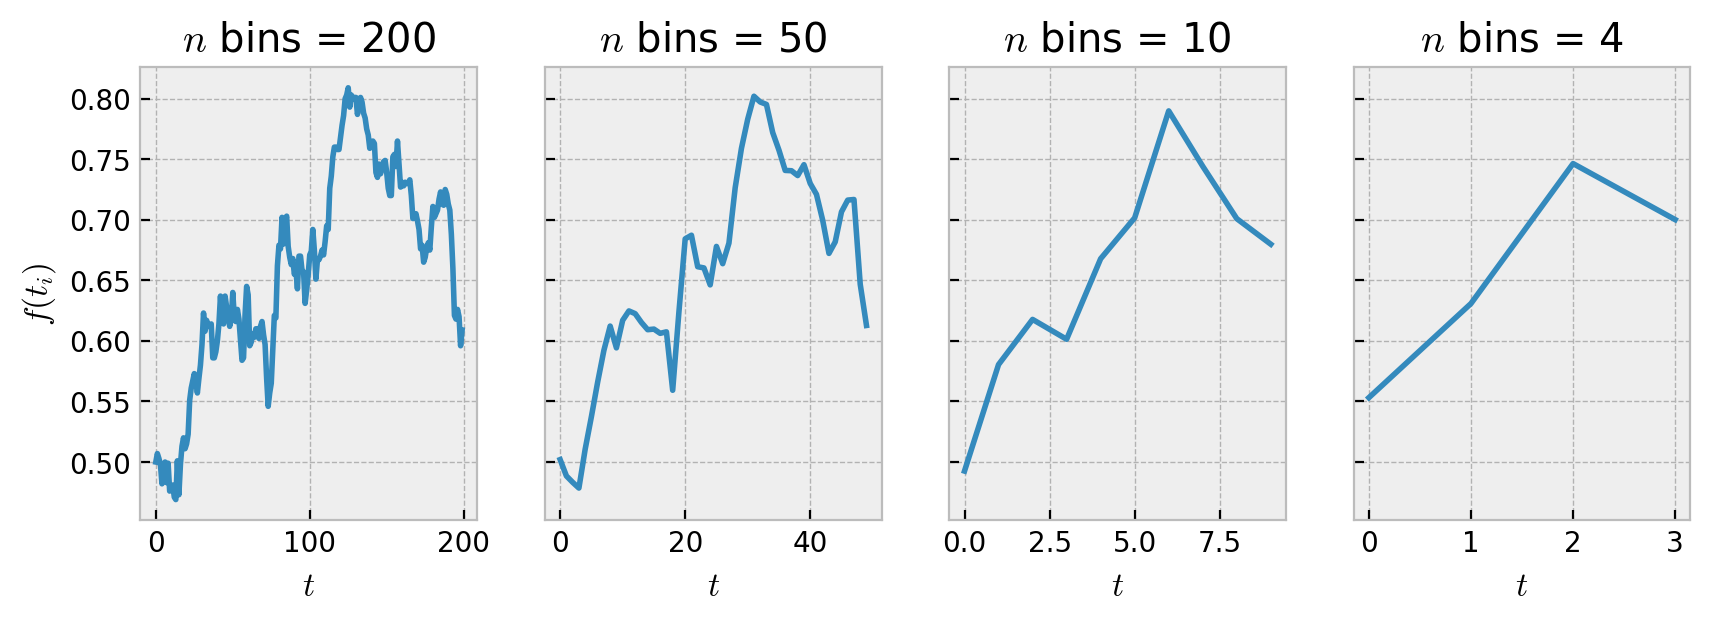

In [77]:
series = wright_fisher(N=1000, T=200, selection_strength=0)
bins = 200, 50, 10, 4

fig, axes = plt.subplots(ncols=4, dpi=200, figsize=(10, 3), sharey=True)
axes = axes.flat

for i, n_bins in enumerate(bins):
    f = apply_binning(series, n_bins, n_agents=1000)
    axes[i].plot(f)
    axes[i].set(xlabel="$t$", title=f"$n$ bins = {n_bins}")
    if i == 0:
        axes[i].set_ylabel("$f(t_i)$")

## Training Procedure

We train the TSC using mini-batches of simulated time series. In each training epoch, 50,000 time series are generated, which, using a batch size of 500, are split into 100 mini-batches. Each time series in a mini-batch, as described above, is then simulated with a selection coefficient $\beta$ in the range $[0, 1]$. Subsequently, it is binned into a randomly sampled number of temporal segments and the bin values are distorted as described
above. To ensure that after varying the number of temporal segments, all time series in a mini-batch have the same length, we apply zero-padding, in which the time series are extended with zeros, as necessary. Positive selection coefficients, $\beta > 0$, are sampled from a log-uniform distribution, which ensures that we obtain many samples with low selection pressure. These samples are the most difficult ones to distinguish from stochastic drift, and as such, help the network in reaching more efficient and faster convergence. Importantly, the ratio of positive and negative instances in the data are kept balanced in the generated data (i.e. 50\%-50\%). We employ the Adam optimizer with a small learning rate of 6e-5. The loss function we aim to optimize is the binary cross-entropy loss.

For each epoch in the optimization regime, a new set of training data is generated. We monitor the network's performance after each epoch on a held-out development set (that is generated analogously to the training data, but only once at the start of the regime). Finally, the training procedure is halted after no improvement in the loss on the development data has been observed for five, consecutive epochs.